In [2]:
import json
import pandas as pd
import numpy as np
import modules.LP_Pool_State as lpps
import warnings
warnings.filterwarnings('ignore')


In [ ]:
with open("config.json", 'r') as f:
    args = json.load(f)
with open("MP_ASSET_STATE.csv", "r") as outfile:
    MP_Asset_State = pd.read_csv(outfile, index_col=0)
with open("MP_ASSET.csv", "r") as outfile:
    MP_Asset = pd.read_csv(outfile, index_col=0)

LS_Opening = pd.read_csv("LS_Opening", index_col=0)
LP_Deposit = pd.read_csv("LP_Deposit", index_col=0)
LP_Withdraw = pd.read_csv("LP_Withdraw", index_col=0)
SYS_LP_Withdraw = pd.read_csv("SYS_LP_Withdraw", index_col=0)

LS_Repayment = pd.read_csv("LS_Repayment", index_col=0)
LS_Closing = pd.read_csv("LS_Closing", index_col=0)
LS_Liquidation = pd.read_csv("LS_Liquidation", index_col=0)
pool_id = lpps.LP_pool_gen(args)
pool_id


def LP_pool_gen(args):
    list_id = ["pid" + str(sub) for sub in range(100, 100 + len(args["Pool_Assets"]))]
    #
    lpp = pd.DataFrame({"LP_Pool_id": list_id, "LP_symbol": args["Pool_Assets"]})
    return lpp


LP_Pool_State = pd.read_csv("LP_Pool_State.csv", index_col=0)


In [2]:
LS_Repayment

,LS_timestamp,LS_contract_id,LS_repayment_height,LS_repayment_idx,LS_symbol,LS_amnt_stable,LS_principal_stable,LS_current_margin_stable,LS_current_interest_stable,LS_prev_interest_stable,LS_prev_margin_stable
0,2020-09-21 03:00:00,LScid1000000,100,100,tether,0,0,0,0,0,0
1,2020-10-21 03:00:00,LScid1000000,101,101,tether,0,0,0,0,0,0
2,2020-11-20 02:00:00,LScid1000000,102,102,tether,0,0,0,0,0,0
3,2020-09-21 03:00:00,LScid1000001,103,103,tether,0,0,0,0,0,0
4,2020-10-21 03:00:00,LScid1000001,104,104,tether,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
412483,2022-11-19 02:00:00,LScid1073047,412583,412583,usd-coin,0,0,0,0,0,0
412484,2022-12-19 02:00:00,LScid1073047,412584,412584,usd-coin,0,0,0,0,0,0
412485,2023-01-18 02:00:00,LScid1073047,412585,412585,usd-coin,0,0,0,0,0,0
412486,2023-02-17 02:00:00,LScid1073047,412586,412586,usd-coin,0,0,0,0,0,0


In [3]:
def get_timestamps(MP_Asset):
    timestamps = pd.DataFrame()
    timestamps = MP_Asset.drop_duplicates(subset=["MP_timestamp"])
    timestamps = pd.DataFrame(timestamps["MP_timestamp"])
    timestamps.rename(columns={"MP_timestamp": "PL_Interest_timestamp"})
    return timestamps


In [4]:
def calculate_interest(timestamp, LP_Pool_State, pool_util, args):
    # util = pd["id":Util]

    pools = LP_Pool_State.loc[LP_Pool_State["LP_Pool_timestamp"] == timestamp]
    pools = pools[["LP_Pool_id", "LP_Pool_total_borrowed_stable", "LP_Pool_total_deposited_stable"]]
    # pools = pools.rename(columns={"LP_Pool_id":"id"})
    pools = pd.merge(pools, pool_util, on="LP_Pool_id", how="left")
    util = (pools["LP_Pool_total_borrowed_stable"] / (
            pools["LP_Pool_total_deposited_stable"] + pools["LP_Pool_total_borrowed_stable"]))
    pools.loc[pools["Util"] <= args["optimal_util"] / 100, ["interest"]] = args["base_interest"] / 100 + (
            util / (args["optimal_util"] / 100)) * (args["slope1"] / 100)
    pools.loc[pools["Util"] > args["optimal_util"] / 100, ["interest"]] = args["base_interest"] / 100 + args[
        "slope1"] / 100 + (((util - args["optimal_util"] / 100) / (1 - args["optimal_util"] / 100)) * args[
        "slope2"] / 100)
    # HARDCODE CAP
    pools.loc[pools["interest"] > args["LS_interest_cap"] / 100, ["interest"]] = args["LS_interest_cap"] / 100
    pool_util["Util"] = util

    pools = pools.drop(["LP_Pool_total_borrowed_stable", "LP_Pool_total_deposited_stable", "Util"], axis=1)
    return pools, pool_util


In [5]:

def LS_fill_interest(timestamp, pool_interest, LS_Opening, LS_Repayment, LS_Liquidation, pool_id, args):
    # LS_Repayment
    contract_ids = LS_Opening[["LS_contract_id", "LS_loan_amnt_stable", "LP_Pool_id", "SYS_LS_expected_payment",
                               "SYS_LS_expected_penalty"]].loc[LS_Opening["LS_timestamp"] == timestamp]
    p_i = dict(pool_interest.values)
    LS_Opening["LS_interest"].loc[LS_Opening["LS_timestamp"] == timestamp] = LS_Opening["LP_Pool_id"].loc[
        LS_Opening["LS_timestamp"] == timestamp].map(p_i)
    amnt = contract_ids["LS_loan_amnt_stable"]
    payment = contract_ids["SYS_LS_expected_payment"]
    penalty = contract_ids["SYS_LS_expected_penalty"]
    pool = contract_ids["LP_Pool_id"]
    contract_ids = pd.merge(contract_ids, pool_interest, on="LP_Pool_id", how='left')
    
    contract_ids["repayment_amnt"] = contract_ids["LS_loan_amnt_stable"] * (
            1 + contract_ids["interest"] * (1 - contract_ids["SYS_LS_expected_penalty"] / 12)) / (
                                             contract_ids["SYS_LS_expected_payment"] + contract_ids[
                                         "SYS_LS_expected_penalty"])

    contract_ids["liquidation_amnt"] = contract_ids["LS_loan_amnt_stable"] * (
        (contract_ids["interest"] * contract_ids["SYS_LS_expected_penalty"] / 12)) / (
                                               contract_ids["SYS_LS_expected_payment"] + contract_ids[
                                           "SYS_LS_expected_penalty"])
    
    contract_ids["ls_principal_stable"] = contract_ids["LS_loan_amnt_stable"] / (contract_ids["SYS_LS_expected_payment"] + contract_ids[
                                           "SYS_LS_expected_penalty"])
    contract_ids["ls_rep_margins"] = (contract_ids["repayment_amnt"]-contract_ids["ls_principal_stable"])/ 4#distribution over margins/interest

    contract_ids = contract_ids.drop(
        ["LS_loan_amnt_stable", "LP_Pool_id", "SYS_LS_expected_payment", "SYS_LS_expected_penalty"], axis=1)
    rep = contract_ids[["LS_contract_id", "repayment_amnt"]]
    rep = rep.rename(columns={"repayment_amnt": "LS_amnt_stable"})
    rep_val = dict(rep.values)
    liq = contract_ids[["LS_contract_id", "liquidation_amnt"]]
    liq = liq.rename(columns={"liquidation_amnt": "LS_amnt_stable"})
    liq_val = dict(liq.values)
    principal = contract_ids[["LS_contract_id", "ls_principal_stable"]]
    principal = principal.rename(columns={"ls_principal_stable": "LS_principal_stable"})
    margins = contract_ids[["LS_contract_id", "ls_rep_margins"]]
    ls_curr_margins = margins.rename(columns={"ls_rep_margins": "LS_current_margin_stable"})
    ls_curr_interest = margins.rename(columns={"ls_rep_margins": "LS_current_interest_stable"})
    ls_prev_interest = margins.rename(columns={"ls_rep_margins": "LS_prev_interest_stable"})
    ls_prev_margins = margins.rename(columns={"ls_rep_margins": "LS_prev_margin_stable"})


    LS_Repayment.loc[LS_Repayment["LS_contract_id"].isin(rep["LS_contract_id"]), "LS_amnt_stable"] = LS_Repayment.loc[
        LS_Repayment["LS_contract_id"].isin(rep["LS_contract_id"]), "LS_contract_id"].map(rep_val)

    LS_Repayment.loc[LS_Repayment["LS_contract_id"].isin(principal["LS_contract_id"]), "LS_principal_stable"] = \
    LS_Repayment.loc[LS_Repayment["LS_contract_id"].isin(principal["LS_contract_id"]), "LS_contract_id"].map(dict(principal.values))

    LS_Repayment.loc[
        LS_Repayment["LS_contract_id"].isin(ls_curr_margins["LS_contract_id"]), "LS_current_margin_stable"] = \
    LS_Repayment.loc[LS_Repayment["LS_contract_id"].isin(ls_curr_margins["LS_contract_id"]), "LS_contract_id"].map(
        dict(ls_curr_margins.values))

    LS_Repayment.loc[
        LS_Repayment["LS_contract_id"].isin(ls_curr_interest["LS_contract_id"]), "LS_current_interest_stable"] = \
    LS_Repayment.loc[LS_Repayment["LS_contract_id"].isin(ls_curr_interest["LS_contract_id"]), "LS_contract_id"].map(
        dict(ls_curr_interest.values))

    LS_Repayment.loc[
        LS_Repayment["LS_contract_id"].isin(ls_prev_interest["LS_contract_id"]), "LS_prev_interest_stable"] = \
    LS_Repayment.loc[LS_Repayment["LS_contract_id"].isin(ls_prev_interest["LS_contract_id"]), "LS_contract_id"].map(
        dict(ls_prev_interest.values))
    LS_Repayment.loc[LS_Repayment["LS_contract_id"].isin(ls_prev_margins["LS_contract_id"]), "LS_prev_margin_stable"] = \
    LS_Repayment.loc[LS_Repayment["LS_contract_id"].isin(ls_prev_margins["LS_contract_id"]), "LS_contract_id"].map(
        dict(ls_prev_margins.values))

    LS_Liquidation.loc[LS_Liquidation["LS_contract_id"].isin(liq["LS_contract_id"]), "LS_amnt_stable"] = \
    LS_Liquidation.loc[LS_Liquidation["LS_contract_id"].isin(liq["LS_contract_id"]), "LS_contract_id"].map(liq_val)

    LS_Liquidation.loc[LS_Liquidation["LS_contract_id"].isin(principal["LS_contract_id"]), "LS_principal_stable"] = \
    LS_Liquidation.loc[LS_Liquidation["LS_contract_id"].isin(principal["LS_contract_id"]), "LS_contract_id"].map(dict(principal.values))
    LS_Liquidation.loc[
        LS_Liquidation["LS_contract_id"].isin(ls_curr_margins["LS_contract_id"]), "LS_current_margin_stable"] = \
    LS_Liquidation.loc[LS_Liquidation["LS_contract_id"].isin(ls_curr_margins["LS_contract_id"]), "LS_contract_id"].map(
        dict(ls_curr_margins.values))
    LS_Liquidation.loc[
        LS_Liquidation["LS_contract_id"].isin(ls_curr_interest["LS_contract_id"]), "LS_current_interest_stable"] = \
    LS_Liquidation.loc[LS_Liquidation["LS_contract_id"].isin(ls_curr_interest["LS_contract_id"]), "LS_contract_id"].map(
        dict(ls_curr_interest.values))
    LS_Liquidation.loc[
        LS_Liquidation["LS_contract_id"].isin(ls_prev_interest["LS_contract_id"]), "LS_prev_interest_stable"] = \
    LS_Liquidation.loc[LS_Liquidation["LS_contract_id"].isin(ls_prev_interest["LS_contract_id"]), "LS_contract_id"].map(
        dict(ls_prev_interest.values))
    LS_Liquidation.loc[
        LS_Liquidation["LS_contract_id"].isin(ls_prev_margins["LS_contract_id"]), "LS_prev_margin_stable"] = \
    LS_Liquidation.loc[LS_Liquidation["LS_contract_id"].isin(ls_prev_margins["LS_contract_id"]), "LS_contract_id"].map(
        dict(ls_prev_margins.values))

    repayment_sum = LS_Repayment.loc[LS_Repayment["LS_timestamp"] == timestamp, ["LS_symbol", "LS_amnt_stable"]]
    liquidation_sum = LS_Liquidation.loc[LS_Liquidation["LS_timestamp"] == timestamp, ["LS_symbol", "LS_amnt_stable"]]

    repayment_sum = repayment_sum.groupby("LS_symbol")["LS_amnt_stable"].sum()
    liquidation_sum = liquidation_sum.groupby("LS_symbol")["LS_amnt_stable"].sum()

    if repayment_sum.empty == True:
        repayment_sum = pd.DataFrame({"LS_symbol": args["Pool_Assets"], "LS_amnt_stable": 0})
    else:
        repayment_sum = repayment_sum.reset_index()
        repayment_sum = repayment_sum.fillna(0)
    if liquidation_sum.empty == True:
        liquidation_sum = pd.DataFrame({"LS_symbol": args["Pool_Assets"], "LS_amnt_stable": 0})
    else:
        liquidation_sum = liquidation_sum.reset_index()
        liquidation_sum = liquidation_sum.fillna(0)
    return LS_Opening, LS_Repayment, LS_Liquidation, repayment_sum, liquidation_sum

In [6]:
def fill_withdraw(timestamp, LP_Withdraw, LP_Deposit, SYS_LP_Withdraw):
    if timestamp in LP_Withdraw["LP_timestamp"].values:
        contract_id = LP_Withdraw[["SYS_LP_contract_id", "LP_amnt_stable", "LP_Pool_id"]].loc[
            LP_Withdraw["LP_timestamp"] == timestamp]
        interest = SYS_LP_Withdraw[["SYS_LP_contract_id", "LP_interest_amnt"]]
        cond = interest["SYS_LP_contract_id"].isin(contract_id["SYS_LP_contract_id"])
        interest = interest.loc[cond].groupby("SYS_LP_contract_id").apply(pd.Series.sum, skipna=True)
        interest = interest.drop("SYS_LP_contract_id", axis=1)
        interest = interest.reset_index()
        deposited = LP_Deposit.loc[LP_Deposit["SYS_LP_contract_id"].isin(contract_id["SYS_LP_contract_id"])]
        deposited = deposited[["SYS_LP_contract_id", "LP_amnt_stable"]]
        deposited = dict(deposited.values)
        interest["base"] = interest["SYS_LP_contract_id"].map(deposited)
        interest["LP_amnt_stable"] = interest["base"] + interest["LP_interest_amnt"]
        interest = interest.drop(["base", "LP_interest_amnt"], axis=1)
        # print(interest)
        interest = dict(interest.values)
        LP_Withdraw.loc[LP_Withdraw["LP_timestamp"]==timestamp,"LP_amnt_stable"] = LP_Withdraw.loc[LP_Withdraw["LP_timestamp"]==timestamp,"SYS_LP_contract_id"].map(interest)
    return LP_Withdraw

In [7]:
def LP_fill_interest(timestamp, pool_interest, LP_Deposit, LP_Withdraw, SYS_LP_Withdraw, pool_id, args):
    # update - contract_id -> contract_id
    p_i = pool_interest
    p_i["interest"] = p_i["interest"] - args["treasury_interest"] / 100
    contract_id = SYS_LP_Withdraw[["SYS_LP_contract_id"]].loc[SYS_LP_Withdraw["LP_timestamp"] == timestamp]
    contract_id = LP_Deposit[["SYS_LP_contract_id", "LP_amnt_stable", "LP_Pool_id"]].loc[
        LP_Deposit["SYS_LP_contract_id"].isin(contract_id["SYS_LP_contract_id"])]
    amnt = contract_id[["SYS_LP_contract_id", "LP_amnt_stable"]]
    amnt = dict(amnt.values)
    pool = contract_id["LP_Pool_id"]

    contract_id = pd.merge(contract_id, p_i, on="LP_Pool_id", how='left')
    p_i = dict(p_i.values)
    SYS_LP_Withdraw.loc[SYS_LP_Withdraw["LP_timestamp"] == timestamp, "LP_interest"] = SYS_LP_Withdraw[
        "LP_Pool_id"].map(p_i)
    SYS_LP_Withdraw.loc[SYS_LP_Withdraw["LP_timestamp"] == timestamp,"LP_amnt_stable"] = SYS_LP_Withdraw["SYS_LP_contract_id"].loc[SYS_LP_Withdraw["LP_timestamp"] == timestamp].map(amnt)
    
    #a = SYS_LP_Withdraw.loc[SYS_LP_Withdraw["LP_timestamp"] == timestamp]
    time = SYS_LP_Withdraw.loc[
        SYS_LP_Withdraw["LP_timestamp"] == timestamp, ["LP_amnt_stable", "LP_interest", "SYS_LP_contract_id"]]
    time["LP_interest_amnt"] = time["LP_amnt_stable"] * (time[
        "LP_interest"] / 365)
    time = time.drop(["LP_interest", "LP_amnt_stable"], axis=1)
    time = dict(time.values)
    SYS_LP_Withdraw.loc[SYS_LP_Withdraw["LP_timestamp"] == timestamp, "LP_interest_amnt"] = \
        SYS_LP_Withdraw["SYS_LP_contract_id"].loc[SYS_LP_Withdraw["LP_timestamp"] == timestamp].map(time)

    LP_Withdraw = fill_withdraw(timestamp, LP_Withdraw, LP_Deposit, SYS_LP_Withdraw)

    withdraw_sum = LP_Withdraw.loc[LP_Withdraw["LP_timestamp"] == timestamp, ["LP_Pool_id", "LP_amnt_stable"]]
    # print(withdraw_sum)
    withdraw_sum = withdraw_sum.groupby("LP_Pool_id")["LP_amnt_stable"].sum()
    if withdraw_sum.empty == True:
        withdraw_sum = pd.DataFrame({"LP_Pool_id": pool_id["LP_Pool_id"], "LS_amnt_stable": 0})
    else:
        withdraw_sum = withdraw_sum.reset_index()
        withdraw_sum = withdraw_sum.fillna(0)
    return LP_Deposit, LP_Withdraw, SYS_LP_Withdraw, withdraw_sum



In [8]:
def additions_check(withdraw_sum, liquidation_sum, repayment_sum):
    repayment_sum_model = pd.DataFrame({"LP_Pool_id": pool_id["LP_Pool_id"], "LS_amnt_stable": 0})
    liquidation_sum_model = pd.DataFrame({"LP_Pool_id": pool_id["LP_Pool_id"], "LS_amnt_stable": 0})
    withdraw_sum_model = pd.DataFrame({"LP_Pool_id": pool_id["LP_Pool_id"], "LP_amnt_stable": 0})

    try:
        liquidation_sum = {v: k for k, v in dict(liquidation_sum.values).items()}
        liquidation_sum_model["LS_amnt_stable"] = liquidation_sum_model["LP_Pool_id"].map(liquidation_sum).fillna(0)
    except:
        pass

    try:
        repayment_sum = {v: k for k, v in dict(repayment_sum.values).items()}
        repayment_sum_model["LS_amnt_stable"] = repayment_sum_model["LP_Pool_id"].map(repayment_sum).fillna(0)
    except:
        pass

    try:
        withdraw_sum = dict(withdraw_sum.values)
        withdraw_sum_model["LP_amnt_stable"] = withdraw_sum_model["LP_Pool_id"].map(withdraw_sum).fillna(0)
    except:
        pass

    repayment_sum = dict(repayment_sum_model.values)
    liquidation_sum = dict(liquidation_sum_model.values)
    withdraw_sum = dict(withdraw_sum_model.values)

    return withdraw_sum, liquidation_sum, repayment_sum


In [9]:
def check_util(timestamp, pool_util, LS_Opening, LS_Repayment, LS_Liquidation, LP_Pool_State,borrowed, args):
    pid = pool_util.loc[pool_util["Util"] >= args["max_pool_util"] / 100]
    if pid.empty:
        return pool_util, LS_Opening, LS_Repayment, LS_Liquidation, LP_Pool_State, False

    contract_ids = LS_Opening[["LS_contract_id", "LP_Pool_id"]].loc[LS_Opening["LS_timestamp"] == timestamp]
    contract_ids = contract_ids.loc[contract_ids["LP_Pool_id"].isin(pid["LP_Pool_id"])]

    LS_Opening = LS_Opening.loc[~LS_Opening["LS_contract_id"].isin(contract_ids["LS_contract_id"])]
    LS_Repayment = LS_Repayment.loc[~LS_Repayment["LS_contract_id"].isin(contract_ids["LS_contract_id"])]
    LS_Liquidation = LS_Liquidation.loc[~LS_Liquidation["LS_contract_id"].isin(contract_ids["LS_contract_id"])]
    LP_Pool_State["LP_Pool_total_borrowed_stable"].loc[(LP_Pool_State["LP_Pool_timestamp"]==timestamp) & (LP_Pool_State["LP_Pool_id"].isin(pid["LP_Pool_id"]))] = 0
    LP_Pool_State["LP_Pool_total_borrowed_stable"].loc[(LP_Pool_State["LP_Pool_timestamp"]==timestamp) & (~LP_Pool_State["LP_Pool_id"].isin(pid["LP_Pool_id"]))] = LP_Pool_State["LP_Pool_id"].loc[(LP_Pool_State["LP_Pool_timestamp"]==timestamp) & (~LP_Pool_State["LP_Pool_id"].isin(pid["LP_Pool_id"]))].map(dict(borrowed.values))

    #LP_Pool_State.loc[(~LP_Pool_State["LP_Pool_id"].isin(pid["LP_Pool_id"])) and LP_Pool_State["LP_Pool_timestamp"]==timestamp,"LP_Pool_total_borrowed_stable"] = pid["LP_Pool_id"].map(dict(borrowed.values))


    return pool_util, LS_Opening, LS_Repayment, LS_Liquidation, LP_Pool_State, True

    

In [10]:
def LP_interest_calculate(LS_Opening, LP_Deposit, LS_Repayment, LS_Liquidation, LP_Withdraw, SYS_LP_Withdraw,
                          LP_Pool_State,LS_Closing,pool_id, args):
    repayment_sum = 0
    liquidation_sum = 0
    withdraw_sum = 0
    i = 0

    PL_Interest = pd.DataFrame(
        {"PL_timestamp": [], "LP_Pool_id": [], "PL_borrowed_stable": [], "PL_deposited_stable": [], "Util": [],
         "LS_interest": [], "LP_interest": []})
    timestamps = get_timestamps(MP_Asset)
    pool_util = pd.DataFrame({"LP_Pool_id": pool_id["LP_Pool_id"], "Util": np.zeros(len(pool_id))})
    pool_interest = pd.DataFrame(
        {"LP_Pool_id": pool_id["LP_Pool_id"], "interest": np.ones(len(pool_id)) * 0.1})  # change from conf
    symbol_id = {v: k for k, v in dict(pool_id.values).items()}
    sum_deposited = pd.DataFrame(
        {"LP_Pool_id": pool_id["LP_Pool_id"], "LP_Pool_total_deposited_stable": np.zeros(len(pool_id))})
    sum_borrowed = pd.DataFrame(
        {"LP_Pool_id": pool_id["LP_Pool_id"], "LP_Pool_total_borrowed_stable": np.zeros(len(pool_id))})
    i = 0
    pool_interest_prev = pool_interest.copy()
    pool_util_prev = pool_util.copy()
    sum_borrowed_prev = sum_borrowed.copy()
    sum_deposited_prev = sum_deposited.copy()
    while i < len(timestamps):
        timestamp = timestamps.values[i][0]
        i = i + 1
        print("REPORT!")
        print("Timestamp:\n", timestamp)
        print("Pool_utilisation:\n", pool_util)
        print("withdraw_sum:\n", withdraw_sum)
        print("liquidation_sum:\n", liquidation_sum)
        print("repayment_sum:\n", repayment_sum)
        withdraw_sum, liquidation_sum, repayment_sum = additions_check(withdraw_sum, liquidation_sum, repayment_sum)
        withdraw_sum_prev = withdraw_sum
        liquidation_sum_prev = liquidation_sum
        repayment_sum_prev = repayment_sum

        cond = LP_Pool_State["LP_Pool_timestamp"] == timestamp
        borrowed = LP_Pool_State.loc[cond, ["LP_Pool_id", "LP_Pool_total_borrowed_stable"]].reset_index(drop=True)
        deposited = LP_Pool_State.loc[cond, ["LP_Pool_id", "LP_Pool_total_deposited_stable"]].reset_index(drop=True)
        sum_borrowed["LP_Pool_total_borrowed_stable"] = borrowed["LP_Pool_id"].map(dict(sum_borrowed.values)) + \
                                                        borrowed["LP_Pool_total_borrowed_stable"] - (
                                                                borrowed["LP_Pool_id"].map(repayment_sum) + borrowed[
                                                            "LP_Pool_id"].map(liquidation_sum))

        sum_deposited["LP_Pool_total_deposited_stable"] = deposited["LP_Pool_id"].map(dict(sum_deposited.values)) + \
                                                          deposited["LP_Pool_total_deposited_stable"] - (
                                                              deposited["LP_Pool_id"].map(withdraw_sum))
        
        LP_Pool_State.loc[cond, ["LP_Pool_total_borrowed_stable"]] = LP_Pool_State.loc[cond, "LP_Pool_id"].map(
            dict(sum_borrowed.values))
        LP_Pool_State.loc[cond, ["LP_Pool_total_deposited_stable"]] = LP_Pool_State.loc[cond, "LP_Pool_id"].map(
            dict(sum_deposited.values))

        add = LP_Pool_State.loc[LP_Pool_State["LP_Pool_timestamp"] == timestamp, ["LP_Pool_timestamp", "LP_Pool_id",
                                                                                  "LP_Pool_total_borrowed_stable",
                                                                                  "LP_Pool_total_deposited_stable"]]
        add = add.rename(columns={"LP_Pool_timestamp": "PL_timestamp", "LP_total_borrowed_stable": "PL_borrowed_stable",
                                  "LP_Pool_total_deposited_stable": "PL_deposited_stable"})
        add["Util"] = add["LP_Pool_id"].map(dict(pool_util.values))
        add["LS_interest"] = add["LP_Pool_id"].map(dict(pool_interest.values))

        LS_Opening, LS_Repayment, LS_Liquidation, repayment_sum, liquidation_sum = LS_fill_interest(timestamp,
                                                                                                    pool_interest,
                                                                                                    LS_Opening,
                                                                                                    LS_Repayment,
                                                                                                    LS_Liquidation,
                                                                                                    pool_id, args)
        repayment_sum["LP_Pool_id"] = repayment_sum["LS_symbol"].map(symbol_id)
        repayment_sum = repayment_sum.drop("LS_symbol", axis=1)
        liquidation_sum["LP_Pool_id"] = liquidation_sum["LS_symbol"].map(symbol_id)
        liquidation_sum = liquidation_sum.drop("LS_symbol", axis=1)
        # LP INTERES
        LP_Deposit, LP_Withdraw, SYS_LP_Withdraw, withdraw_sum = LP_fill_interest(timestamp, pool_interest, LP_Deposit,
                                                                                  LP_Withdraw, SYS_LP_Withdraw, pool_id,
                                                                                  args)
        pool_interest, pool_util = calculate_interest(timestamp, LP_Pool_State, pool_util, args)
        pool_util, LS_Opening, LS_Repayment, LS_Liquidation, LP_Pool_State, check = check_util(timestamp, pool_util,
                                                                                               LS_Opening, LS_Repayment,
                                                                                               LS_Liquidation,
                                                                                               LP_Pool_State,borrowed, args)
        if check:#if any pool_util > more
            withdraw_sum = withdraw_sum_prev
            liquidation_sum = liquidation_sum_prev
            repayment_sum = repayment_sum_prev
            pool_interest = pool_interest_prev.copy()
            pool_util = pool_util_prev.copy()
            LP_Pool_State.loc[cond, ["LP_Pool_total_deposited_stable"]] = LP_Pool_State.loc[cond, "LP_Pool_id"].map(
                dict(deposited.values))
            sum_borrowed = sum_borrowed_prev.copy()
            sum_deposited = sum_deposited_prev.copy()
            i = i - 1
        else:
            pool_interest_prev = pool_interest.copy()
            pool_util_prev = pool_util.copy()
            sum_borrowed_prev = sum_borrowed.copy()
            sum_deposited_prev = sum_deposited.copy()
            PL_Interest = PL_Interest.append(add)

    return LS_Opening, LP_Deposit, LS_Repayment, LS_Liquidation, LP_Withdraw, LP_Pool_State, SYS_LP_Withdraw, PL_Interest


In [11]:
LS_Opening

,LS_asset_symbol,LS_timestamp,LS_contract_id,LS_address_id,LS_loan_symbol,LS_loan_amnt_asset,LS_loan_amnt_stable,LS_cltr_symbol,LS_cltr_amnt_stable,LS_cltr_amnt_asset,SYS_LS_cltr_amnt_asset,SYS_LS_loan_amnt_asset,LS_native_amnt_nolus,LS_native_amnt_stable,SYS_LS_expected_payment,SYS_LS_expected_penalty,LP_Pool_id,LS_interest
0,solana,2020-08-22 03:00:00,LScid1000000,LS_aid1000000,"('solana', None, 16)",146120851640169,4283606072121,solana,5936057173648,202488677762287,2.024887,1.461209,0,0,3,0,pid101,NaN
1,ethereum,2020-08-22 03:00:00,LScid1000001,LS_aid1000001,"('ethereum', None, 13)",8041181306339,310878269545215,ethereum,394108143559885,10194006294830,1.019401,0.804118,0,0,2,0,pid101,NaN
2,usd-coin,2020-08-22 03:00:00,LScid1000002,LS_aid1000002,"('usd-coin', None, 16)",501203184993,501020135184,usd-coin,659006249718,659247020416,0.659247,0.501203,0,0,3,1,pid100,NaN
3,matic-network,2020-08-22 03:00:00,LScid1000003,LS_aid1000003,"('matic-network', None, 16)",10738170597123684,26797738702,matic-network,39790148758,15944382852572164,1.594438,1.073817,0,0,2,0,pid101,NaN
4,crypto-com-chain,2020-08-22 03:00:00,LScid1000004,LS_aid1000004,"('crypto-com-chain', None, 15)",6969856732475531,117280371682,crypto-com-chain,121202182911,7202926102989536,0.720293,0.696986,0,0,5,8,pid101,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73043,tether,2022-08-21 03:00:00,LScid1073043,LS_aid1073043,"('tether', None, 12)",1158363644598,1159646859896,tether,1190204761684,1188887732327,1.188888,1.158364,0,0,1,0,pid101,NaN
73044,bitcoin,2022-08-21 03:00:00,LScid1073044,LS_aid1073044,"('bitcoin', None, 12)",1233262442095,26122219920255380,bitcoin,26956457674587960,1272647842469,1.272648,1.233262,0,0,1,0,pid101,NaN
73045,wrapped-bitcoin,2022-08-21 03:00:00,LScid1073045,LS_aid1073045,"('wrapped-bitcoin', None, 12)",1522935880862,32224525557920664,wrapped-bitcoin,35167825880797500,1662036692814,1.662037,1.522936,0,0,5,0,pid101,NaN
73046,tether,2022-08-21 03:00:00,LScid1073046,LS_aid1073046,"('tether', None, 12)",1236486906930,1237171596812,tether,1280949110456,1280240192713,1.280240,1.236487,0,0,6,0,pid100,NaN


In [12]:
def LS_int_main():
    with open("config.json", 'r') as f:
        args = json.load(f)
    with open("MP_ASSET_STATE.csv", "r") as outfile:
        MP_Asset_State = pd.read_csv(outfile, index_col=0)
    with open("MP_ASSET.csv", "r") as outfile:
        MP_Asset = pd.read_csv(outfile, index_col=0)

    LS_Opening = pd.read_csv("LS_Opening", index_col=0)
    LP_Deposit = pd.read_csv("LP_Deposit", index_col=0)
    LP_Withdraw = pd.read_csv("LP_Withdraw", index_col=0)
    SYS_LP_Withdraw = pd.read_csv("SYS_LP_Withdraw", index_col=0)

    LS_Repayment = pd.read_csv("LS_Repayment", index_col=0)
    LS_Closing = pd.read_csv("LS_Closing", index_col=0)
    LS_Liquidation = pd.read_csv("LS_Liquidation", index_col=0)
    pool_id = lpps.LP_pool_gen(args)
    LP_Pool_State = pd.read_csv("LP_Pool_State.csv", index_col=0)

    LS_Opening, LP_Deposit, LS_Repayment, LS_Liquidation, LP_Withdraw, LP_Pool_State, SYS_LP_Withdraw, PL_Interest = LP_interest_calculate(
        LS_Opening, LP_Deposit, LS_Repayment, LS_Liquidation, LP_Withdraw, SYS_LP_Withdraw, LP_Pool_State, pool_id,
        args)
    return LS_Opening, LP_Deposit, LS_Repayment, LS_Liquidation, LP_Withdraw, SYS_LP_Withdraw, LP_Pool_State,PL_Interest


In [15]:
LS_Opening, LP_Deposit, LS_Repayment, LS_Liquidation, LP_Withdraw, SYS_LP_Withdraw, LP_Pool_State,PL_Interest = LS_int_main()

REPORT!
Timestamp:
 2020-08-21 03:00:00
Pool_utilisation:
   LP_Pool_id  Util
0     pid100   0.0
1     pid101   0.0
withdraw_sum:
 0
liquidation_sum:
 0
repayment_sum:
 0
REPORT!
Timestamp:
 2020-08-22 03:00:00
Pool_utilisation:
   LP_Pool_id  Util
0     pid100   0.0
1     pid101   0.0
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0               0     pid100
1               0     pid101
repayment_sum:
    LS_amnt_stable LP_Pool_id
0               0     pid100
1               0     pid101
REPORT!
Timestamp:
 2020-08-23 03:00:00
Pool_utilisation:
   LP_Pool_id          Util
0     pid100  6.252931e-07
1     pid101  1.706564e-02
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0               0     pid100
1               0     pid101
repayment_sum:
    LS_amnt_stable LP_Pool_id
0          

REPORT!
Timestamp:
 2020-09-10 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.608615
1     pid101  0.630051
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0               0     pid100
1               0     pid101
repayment_sum:
    LS_amnt_stable LP_Pool_id
0               0     pid100
1               0     pid101
REPORT!
Timestamp:
 2020-09-11 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.628105
1     pid101  0.637442
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0               0     pid100
1               0     pid101
repayment_sum:
    LS_amnt_stable LP_Pool_id
0               0     pid100
1               0     pid101
REPORT!
Timestamp:
 2020-09-12 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.643034
1     pid101  0.640

REPORT!
Timestamp:
 2020-09-29 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.712759
1     pid101  0.720858
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    3.050781e+13     pid101
1    1.826349e+14     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    2.881680e+16     pid101
1    4.360817e+16     pid100
REPORT!
Timestamp:
 2020-09-30 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.721831
1     pid101  0.714702
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    3.134577e+14     pid101
1    4.154456e+14     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    2.530064e+16     pid101
1    3.431377e+16     pid100
REPORT!
Timestamp:
 2020-10-01 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.714185
1     pid101  0.721

REPORT!
Timestamp:
 2020-10-18 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.724928
1     pid101  0.735842
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    2.101458e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.056512e+15     pid101
1    3.313294e+14     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    5.893239e+16     pid101
1    6.029117e+16     pid100
REPORT!
Timestamp:
 2020-10-19 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.738289
1     pid101  0.724866
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    5.805153e+14     pid101
1    5.638861e+14     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    4.945722e+16     pid101
1    6.454888e+16     pid100
REPORT!
Timestamp:
 2020-10-20 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.722913
1     pid101  0.740483
withdraw_sum:
   LP_Pool_

REPORT!
Timestamp:
 2020-11-06 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.741706
1     pid101  0.728671
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    6.778035e+14     pid101
1    8.175630e+14     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.222919e+17     pid101
1    1.121601e+17     pid100
REPORT!
Timestamp:
 2020-11-07 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.730218
1     pid101  0.741448
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.044803e+15     pid101
1    1.195795e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.258793e+17     pid101
1    1.331735e+17     pid100
REPORT!
Timestamp:
 2020-11-08 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.728952
1     pid101  0.741

REPORT!
Timestamp:
 2020-11-25 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.746152
1     pid101  0.736401
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.243214e+15     pid101
1    1.527476e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.092822e+17     pid101
1    1.898502e+17     pid100
REPORT!
Timestamp:
 2020-11-26 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.734030
1     pid101  0.748919
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.403568e+15     pid101
1    1.056710e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.415572e+17     pid101
1    1.652790e+17     pid100
REPORT!
Timestamp:
 2020-11-27 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.734283
1     pid101  0.748

REPORT!
Timestamp:
 2020-12-15 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.755153
1     pid101  0.743738
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid101    1.699022e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.972702e+15     pid101
1    2.545157e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.900212e+17     pid101
1    2.429452e+17     pid100
REPORT!
Timestamp:
 2020-12-16 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.755178
1     pid101  0.742925
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.466323e+15     pid101
1    2.169864e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.699417e+17     pid101
1    2.080105e+17     pid100
REPORT!
Timestamp:
 2020-12-17 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.753506
1     pid101  0.743256
withdraw_sum:
   LP_Pool_

REPORT!
Timestamp:
 2021-01-04 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.759500
1     pid101  0.769201
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.527715e+15     pid101
1    2.770924e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.983177e+17     pid101
1    2.449670e+17     pid100
REPORT!
Timestamp:
 2021-01-05 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.769883
1     pid101  0.761347
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.693981e+15     pid101
1    1.990431e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    2.597455e+17     pid101
1    2.114500e+17     pid100
REPORT!
Timestamp:
 2021-01-06 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.762417
1     pid101  0.771

REPORT!
Timestamp:
 2021-01-24 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.795104
1     pid101  0.794947
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    4.450400e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    4.752190e+15     pid101
1    3.205013e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    2.896932e+17     pid101
1    2.571922e+17     pid100
REPORT!
Timestamp:
 2021-01-25 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.797256
1     pid101  0.795679
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid101    8.217492e+15
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    2.924237e+15     pid101
1    2.760095e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    3.484620e+17     pid101
1    3.405275e+17     pid100
REPORT!
Timestamp:
 2021-01-26 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.796138
1     pid101  0.797242
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid1

REPORT!
Timestamp:
 2021-02-13 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.809514
1     pid101  0.809239
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    4.129262e+15     pid101
1    4.566404e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    4.634413e+17     pid101
1    4.339411e+17     pid100
REPORT!
Timestamp:
 2021-02-14 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.811958
1     pid101  0.810142
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid101    1.545002e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    3.335137e+15     pid101
1    4.706564e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    3.240650e+17     pid101
1    3.764574e+17     pid100
REPORT!
Timestamp:
 2021-02-15 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.812569
1     pid101  0.810652
withdraw_sum:
   LP_Pool_

REPORT!
Timestamp:
 2021-03-05 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.835971
1     pid101  0.829812
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    4.081095e+16
1     pid101    1.436053e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    5.970041e+15     pid101
1    4.825035e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    4.684507e+17     pid101
1    4.626550e+17     pid100
REPORT!
Timestamp:
 2021-03-06 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.836433
1     pid101  0.830827
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.439015e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    4.102564e+15     pid101
1    4.223963e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    4.671246e+17     pid101
1    3.276355e+17     pid100
REPORT!
Timestamp:
 2021-03-07 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.837459
1     pid101  0.832186
withdraw_sum:
   LP_Pool_

REPORT!
Timestamp:
 2021-03-25 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.844067
1     pid101  0.850300
withdraw_sum:
   LP_Pool_id  LS_amnt_stable
0     pid100               0
1     pid101               0
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    7.755670e+15     pid101
1    8.176462e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    5.641859e+17     pid101
1    6.922931e+17     pid100
REPORT!
Timestamp:
 2021-03-26 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.849482
1     pid101  0.844839
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    6.661713e+16
1     pid101    1.161199e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    6.145605e+15     pid101
1    7.031307e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    5.609657e+17     pid101
1    6.335157e+17     pid100
REPORT!
Timestamp:
 2021-03-27 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.845228
1     pid101  0.850

REPORT!
Timestamp:
 2021-04-14 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.862410
1     pid101  0.856252
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    5.721671e+16
1     pid101    2.728782e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    7.001344e+15     pid101
1    7.529845e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    6.451682e+17     pid101
1    6.494270e+17     pid100
REPORT!
Timestamp:
 2021-04-15 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.856935
1     pid101  0.863331
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    6.016702e+16
1     pid101    2.188602e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    6.817068e+15     pid101
1    1.183637e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    7.445070e+17     pid101
1    8.046908e+17     pid100
REPORT!
Timestamp:
 2021-04-16 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.863940
1     pid101  0.857

REPORT!
Timestamp:
 2021-05-04 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.874291
1     pid101  0.865484
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.788235e+16
1     pid101    4.244008e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    9.549841e+15     pid101
1    1.224191e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    7.629062e+17     pid101
1    8.949888e+17     pid100
REPORT!
Timestamp:
 2021-05-05 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.866241
1     pid101  0.874489
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    4.494027e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    7.847191e+15     pid101
1    9.704395e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    7.835448e+17     pid101
1    6.861034e+17     pid100
REPORT!
Timestamp:
 2021-05-06 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.875904
1     pid101  0.866155
withdraw_sum:
   LP_Pool_

REPORT!
Timestamp:
 2021-05-23 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.882938
1     pid101  0.877326
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    3.180640e+16
1     pid101    2.549942e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.335735e+16     pid101
1    1.107374e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    9.483812e+17     pid101
1    9.091367e+17     pid100
REPORT!
Timestamp:
 2021-05-24 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.877137
1     pid101  0.882488
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    5.076874e+16
1     pid101    8.618800e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.102279e+16     pid101
1    1.227075e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    9.020630e+17     pid101
1    1.104725e+18     pid100
REPORT!
Timestamp:
 2021-05-25 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.881974
1     pid101  0.877

REPORT!
Timestamp:
 2021-06-11 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.881205
1     pid101  0.881495
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    7.057818e+16
1     pid101    4.608830e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.249415e+16     pid101
1    1.480764e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    9.985840e+17     pid101
1    9.794419e+17     pid100
REPORT!
Timestamp:
 2021-06-12 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.881775
1     pid101  0.880989
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.409958e+16
1     pid101    6.697927e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.301487e+16     pid101
1    1.915449e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    9.093723e+17     pid101
1    1.087580e+18     pid100
REPORT!
Timestamp:
 2021-06-13 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.880289
1     pid101  0.882

REPORT!
Timestamp:
 2021-06-30 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.884207
1     pid101  0.884957
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    5.184159e+16
1     pid101    1.189011e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.058935e+16     pid101
1    1.481864e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    8.105125e+17     pid101
1    1.070927e+18     pid100
REPORT!
Timestamp:
 2021-07-01 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.884539
1     pid101  0.885551
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    5.775659e+16
1     pid101    1.183522e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.702333e+16     pid101
1    1.076340e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.150542e+18     pid101
1    8.798015e+17     pid100
REPORT!
Timestamp:
 2021-07-02 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.885583
1     pid101  0.883

REPORT!
Timestamp:
 2021-07-19 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.892758
1     pid101  0.890688
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.403929e+17
1     pid101    1.254855e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.538452e+16     pid101
1    1.820507e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    8.193353e+17     pid101
1    8.749627e+17     pid100
REPORT!
Timestamp:
 2021-07-20 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.891643
1     pid101  0.893885
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    5.731690e+16
1     pid101    1.048028e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.622984e+16     pid101
1    2.249731e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    8.467031e+17     pid101
1    1.036005e+18     pid100
REPORT!
Timestamp:
 2021-07-21 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.891608
1     pid101  0.894

REPORT!
Timestamp:
 2021-08-01 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899196
1     pid101  0.899401
withdraw_sum:
 {'pid100': 0, 'pid101': 0}
liquidation_sum:
 {'pid100': 0, 'pid101': 0}
repayment_sum:
 {'pid100': 0, 'pid101': 0}
REPORT!
Timestamp:
 2021-08-02 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899314
1     pid101  0.898896
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    2.408242e+17
1     pid101    2.841587e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.261891e+16     pid101
1    1.629964e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.004143e+18     pid101
1    1.201600e+18     pid100
REPORT!
Timestamp:
 2021-08-02 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899314
1     pid101  0.898896
withdraw_sum:
 {'pid100': 2.4082424804343546e+17, 'pid101': 2.841586639123529e+16}
liquidation_sum:
 {'pid100': 1.6299640687554552e+16, 'pid101': 1.2618907924233354e+16}
repaym

REPORT!
Timestamp:
 2021-08-11 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899929
1     pid101  0.899776
withdraw_sum:
 {'pid100': 1.664064499703719e+17, 'pid101': 1.6303154805352378e+17}
liquidation_sum:
 {'pid100': 2.026553719244817e+16, 'pid101': 1.6202631967553202e+16}
repayment_sum:
 {'pid100': 1.0128438483963724e+18, 'pid101': 9.564785748483103e+17}
REPORT!
Timestamp:
 2021-08-12 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899575
1     pid101  0.899788
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.317634e+17
1     pid101    1.252677e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.388170e+16     pid101
1    1.442980e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.000632e+18     pid101
1    7.486229e+17     pid100
REPORT!
Timestamp:
 2021-08-12 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899575
1     pid101  0.899788
withdraw_sum:
 {'pid100': 1.3176340875534022e+17, 'pi

REPORT!
Timestamp:
 2021-08-21 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898719
1     pid101  0.897925
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    9.138914e+16
1     pid101    2.289870e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.486420e+16     pid101
1    1.420577e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    8.037824e+17     pid101
1    8.470581e+17     pid100
REPORT!
Timestamp:
 2021-08-21 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898719
1     pid101  0.897925
withdraw_sum:
 {'pid100': 9.13891448172554e+16, 'pid101': 2.2898699595715706e+17}
liquidation_sum:
 {'pid100': 1.4205772163035812e+16, 'pid101': 1.4864198548691642e+16}
repayment_sum:
 {'pid100': 8.470580730364223e+17, 'pid101': 8.037823957169385e+17}
REPORT!
Timestamp:
 2021-08-22 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899517
1     pid101  0.898480
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid1

REPORT!
Timestamp:
 2021-08-31 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899968
1     pid101  0.899250
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.482954e+17
1     pid101    1.728521e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.639114e+16     pid101
1    1.356303e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    9.622141e+17     pid101
1    7.041955e+17     pid100
REPORT!
Timestamp:
 2021-08-31 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899968
1     pid101  0.899250
withdraw_sum:
 {'pid100': 1.4829538652432467e+17, 'pid101': 1.7285211007161584e+17}
liquidation_sum:
 {'pid100': 1.3563026702172662e+16, 'pid101': 1.6391140503144072e+16}
repayment_sum:
 {'pid100': 7.041955241536177e+17, 'pid101': 9.62214097018158e+17}
REPORT!
Timestamp:
 2021-09-01 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899095
1     pid101  0.899816
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid

REPORT!
Timestamp:
 2021-09-10 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899038
1     pid101  0.898411
withdraw_sum:
 {'pid100': 1.1850279479569709e+17, 'pid101': 1.3327575670905722e+17}
liquidation_sum:
 {'pid100': 2.1198185957572464e+16, 'pid101': 1.7576276182973324e+16}
repayment_sum:
 {'pid100': 1.154250758542309e+18, 'pid101': 1.0293453558915964e+18}
REPORT!
Timestamp:
 2021-09-11 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898889
1     pid101  0.899527
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    7.762694e+16
1     pid101    7.605444e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.303093e+16     pid101
1    1.300655e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    7.073824e+17     pid101
1    5.304760e+17     pid100
REPORT!
Timestamp:
 2021-09-11 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898889
1     pid101  0.899527
withdraw_sum:
 {'pid100': 7.762694191780822e+16, 'p

REPORT!
Timestamp:
 2021-09-21 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899539
1     pid101  0.899003
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    5.981478e+16
1     pid101    1.058053e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.134052e+16     pid101
1    1.620535e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    5.656917e+17     pid101
1    9.485099e+17     pid100
REPORT!
Timestamp:
 2021-09-21 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899539
1     pid101  0.899003
withdraw_sum:
 {'pid100': 5.981477775587296e+16, 'pid101': 1.058053025530815e+17}
liquidation_sum:
 {'pid100': 1.6205349214924292e+16, 'pid101': 1.1340524815713884e+16}
repayment_sum:
 {'pid100': 9.485099319966459e+17, 'pid101': 5.656916512562688e+17}
REPORT!
Timestamp:
 2021-09-21 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899539
1     pid101  0.899003
withdraw_sum:
 {'pid100': 0, 'pid101': 0}
liquidation_

REPORT!
Timestamp:
 2021-10-01 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898569
1     pid101  0.899868
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    8.884021e+16
1     pid101    2.115587e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    9.820667e+15     pid101
1    1.410022e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    4.386533e+17     pid101
1    6.273627e+17     pid100
REPORT!
Timestamp:
 2021-10-01 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898569
1     pid101  0.899868
withdraw_sum:
 {'pid100': 8.88402109589041e+16, 'pid101': 2.1155865414822218e+17}
liquidation_sum:
 {'pid100': 1.4100221359804062e+16, 'pid101': 9820666941473802.0}
repayment_sum:
 {'pid100': 6.273627159524699e+17, 'pid101': 4.386532998662659e+17}
REPORT!
Timestamp:
 2021-10-02 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899792
1     pid101  0.898329
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100  

REPORT!
Timestamp:
 2021-10-11 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899230
1     pid101  0.899377
withdraw_sum:
 {'pid100': 2.195735622675182e+17, 'pid101': 1.1826171284890646e+17}
liquidation_sum:
 {'pid100': 1.1904824709829966e+16, 'pid101': 1.4044175449585866e+16}
repayment_sum:
 {'pid100': 4.2992964230447654e+17, 'pid101': 6.743056444620685e+17}
REPORT!
Timestamp:
 2021-10-12 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899310
1     pid101  0.899062
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    4.223160e+16
1     pid101    1.107670e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.579634e+16     pid101
1    1.433946e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    7.745193e+17     pid101
1    4.324527e+17     pid100
REPORT!
Timestamp:
 2021-10-12 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899310
1     pid101  0.899062
withdraw_sum:
 {'pid100': 4.223159619985664e+16, 'pi

REPORT!
Timestamp:
 2021-10-22 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898371
1     pid101  0.899663
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    9.502906e+16
1     pid101    1.595083e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.171167e+16     pid101
1    9.282254e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    6.623654e+17     pid101
1    3.904444e+17     pid100
REPORT!
Timestamp:
 2021-10-22 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898371
1     pid101  0.899663
withdraw_sum:
 {'pid100': 9.5029058630137e+16, 'pid101': 1.595083247261535e+17}
liquidation_sum:
 {'pid100': 9282253656476188.0, 'pid101': 1.171167072307204e+16}
repayment_sum:
 {'pid100': 3.9044435157737766e+17, 'pid101': 6.623654468389184e+17}
REPORT!
Timestamp:
 2021-10-23 03:00:00
Pool_utilisation:
   LP_Pool_id     Util
0     pid100  0.89818
1     pid101  0.89954
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.4

REPORT!
Timestamp:
 2021-11-01 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899536
1     pid101  0.899301
withdraw_sum:
 {'pid100': 7.767929643835616e+16, 'pid101': 5.263122708433218e+16}
liquidation_sum:
 {'pid100': 1.3125175207234258e+16, 'pid101': 7005946091021428.0}
repayment_sum:
 {'pid100': 3.559435817496872e+17, 'pid101': 3.4364303312072826e+17}
REPORT!
Timestamp:
 2021-11-02 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899098
1     pid101  0.899455
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.691965e+17
1     pid101    1.105084e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.625630e+16     pid101
1    1.074828e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    5.264182e+17     pid101
1    4.321732e+17     pid100
REPORT!
Timestamp:
 2021-11-02 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899098
1     pid101  0.899455
withdraw_sum:
 {'pid100': 1.691964673972603e+17, 'pid101'

REPORT!
Timestamp:
 2021-11-12 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899094
1     pid101  0.898810
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.882084e+17
1     pid101    1.109382e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.327123e+16     pid101
1    7.287181e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    4.289796e+17     pid101
1    2.422238e+17     pid100
REPORT!
Timestamp:
 2021-11-12 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899094
1     pid101  0.898810
withdraw_sum:
 {'pid100': 1.8820840493150685e+17, 'pid101': 1.1093824314596595e+17}
liquidation_sum:
 {'pid100': 7287181339302699.0, 'pid101': 1.3271225809246372e+16}
repayment_sum:
 {'pid100': 2.4222382112913075e+17, 'pid101': 4.289796096559984e+17}
REPORT!
Timestamp:
 2021-11-13 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898688
1     pid101  0.898930
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid10

REPORT!
Timestamp:
 2021-11-22 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898812
1     pid101  0.899786
withdraw_sum:
 {'pid100': 9.44445402739726e+16, 'pid101': 3.611905479161134e+16}
liquidation_sum:
 {'pid100': 9660012997897298.0, 'pid101': 9360805776292540.0}
repayment_sum:
 {'pid100': 2.7971612555495053e+17, 'pid101': 4.281145577197167e+17}
REPORT!
Timestamp:
 2021-11-22 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898812
1     pid101  0.899786
withdraw_sum:
 {'pid100': 0, 'pid101': 0}
liquidation_sum:
 {'pid100': 0, 'pid101': 0}
repayment_sum:
 {'pid100': 0, 'pid101': 0}
REPORT!
Timestamp:
 2021-11-23 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899635
1     pid101  0.898622
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.504750e+17
1     pid101    1.121588e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    7.751498e+15     pid101
1    1.288947e+16     pid100
repayment_sum:
    LS_amnt_stable L

REPORT!
Timestamp:
 2021-12-02 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898804
1     pid101  0.898443
withdraw_sum:
 {'pid100': 9.260812273972603e+16, 'pid101': 4.816508610800495e+16}
liquidation_sum:
 {'pid100': 8706262654841574.0, 'pid101': 1.4152924990301882e+16}
repayment_sum:
 {'pid100': 2.432488427703805e+17, 'pid101': 4.417181396334789e+17}
REPORT!
Timestamp:
 2021-12-03 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898301
1     pid101  0.898682
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.361238e+17
1     pid101    5.989950e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    8.111304e+15     pid101
1    8.301417e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    2.655940e+17     pid101
1    2.878858e+17     pid100
REPORT!
Timestamp:
 2021-12-03 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898301
1     pid101  0.898682
withdraw_sum:
 {'pid100': 1.3612375178082192e+17, 'pid101'

REPORT!
Timestamp:
 2021-12-13 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899068
1     pid101  0.898238
withdraw_sum:
 {'pid100': 1.330012301369863e+17, 'pid101': 1.979296732279266e+17}
liquidation_sum:
 {'pid100': 7313094718324996.0, 'pid101': 9200809537602822.0}
repayment_sum:
 {'pid100': 2.082976198871012e+17, 'pid101': 4.398599223966189e+17}
REPORT!
Timestamp:
 2021-12-14 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898981
1     pid101  0.898008
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    7.649333e+16
1     pid101    9.765472e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.145490e+16     pid101
1    9.828649e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    2.933123e+17     pid101
1    2.314398e+17     pid100
REPORT!
Timestamp:
 2021-12-14 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898981
1     pid101  0.898008
withdraw_sum:
 {'pid100': 7.649333369863014e+16, 'pid101': 9.7

REPORT!
Timestamp:
 2021-12-24 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898925
1     pid101  0.898717
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    2.163734e+17
1     pid101    6.802670e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    7.546420e+15     pid101
1    6.435869e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.967426e+17     pid101
1    1.870158e+17     pid100
REPORT!
Timestamp:
 2021-12-24 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898925
1     pid101  0.898717
withdraw_sum:
 {'pid100': 2.1637339616438355e+17, 'pid101': 6.8026695384885096e+16}
liquidation_sum:
 {'pid100': 6435869356655523.0, 'pid101': 7546420134471312.0}
repayment_sum:
 {'pid100': 1.8701582854057395e+17, 'pid101': 1.9674262166975344e+17}
REPORT!
Timestamp:
 2021-12-25 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898536
1     pid101  0.898855
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100  

REPORT!
Timestamp:
 2022-01-03 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899313
1     pid101  0.899248
withdraw_sum:
 {'pid100': 1.4410179726027398e+17, 'pid101': 8.669684908290246e+16}
liquidation_sum:
 {'pid100': 7148232365888065.0, 'pid101': 9581737069941030.0}
repayment_sum:
 {'pid100': 1.481905474847986e+17, 'pid101': 1.503335689244011e+17}
REPORT!
Timestamp:
 2022-01-04 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899152
1     pid101  0.899136
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    7.077816e+16
1     pid101    6.107222e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.184293e+16     pid101
1    8.725344e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    2.656068e+17     pid101
1    1.953797e+17     pid100
REPORT!
Timestamp:
 2022-01-04 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899152
1     pid101  0.899136
withdraw_sum:
 {'pid100': 7.077815726027397e+16, 'pid101': 6.

REPORT!
Timestamp:
 2022-01-14 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899413
1     pid101  0.898726
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    5.749566e+16
1     pid101    1.070471e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.324940e+16     pid101
1    7.017149e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    7.318803e+17     pid101
1    1.221404e+17     pid100
REPORT!
Timestamp:
 2022-01-14 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899413
1     pid101  0.898726
withdraw_sum:
 {'pid100': 5.74956597260274e+16, 'pid101': 1.0704711207825194e+17}
liquidation_sum:
 {'pid100': 7017149488082794.0, 'pid101': 1.3249401259773248e+16}
repayment_sum:
 {'pid100': 1.2214039148084525e+17, 'pid101': 7.318803426485897e+17}
REPORT!
Timestamp:
 2022-01-15 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899159
1     pid101  0.899754
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100 

REPORT!
Timestamp:
 2022-01-24 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899343
1     pid101  0.898803
withdraw_sum:
 {'pid100': 8.863856657534246e+16, 'pid101': 1.3775811592674874e+17}
liquidation_sum:
 {'pid100': 9721038386275854.0, 'pid101': 1.1339033843203816e+16}
repayment_sum:
 {'pid100': 2.842299559845381e+17, 'pid101': 2.730917080048966e+17}
REPORT!
Timestamp:
 2022-01-25 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899115
1     pid101  0.898767
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.331587e+17
1     pid101    4.004505e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    7.327769e+15     pid101
1    1.079459e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.444130e+17     pid101
1    3.787627e+17     pid100
REPORT!
Timestamp:
 2022-01-25 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899115
1     pid101  0.898767
withdraw_sum:
 {'pid100': 1.3315872383561643e+17, 'pid101

REPORT!
Timestamp:
 2022-02-04 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899456
1     pid101  0.899322
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.360681e+17
1     pid101    1.585689e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.030913e+16     pid101
1    8.116816e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    3.350410e+17     pid101
1    3.042139e+17     pid100
REPORT!
Timestamp:
 2022-02-04 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899456
1     pid101  0.899322
withdraw_sum:
 {'pid100': 1.3606805150684931e+17, 'pid101': 1.585688574721485e+17}
liquidation_sum:
 {'pid100': 8116815542087190.0, 'pid101': 1.0309127208492834e+16}
repayment_sum:
 {'pid100': 3.042139498303897e+17, 'pid101': 3.350410481584211e+17}
REPORT!
Timestamp:
 2022-02-05 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899211
1     pid101  0.899265
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100 

REPORT!
Timestamp:
 2022-02-14 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899917
1     pid101  0.899830
withdraw_sum:
 {'pid100': 1.2767412164383562e+17, 'pid101': 1.5762087303618138e+17}
liquidation_sum:
 {'pid100': 1.0011669738938534e+16, 'pid101': 1.2826363605985114e+16}
repayment_sum:
 {'pid100': 1.4263091832149904e+17, 'pid101': 5.881535768332979e+17}
REPORT!
Timestamp:
 2022-02-15 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899674
1     pid101  0.899807
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    8.560023e+16
1     pid101    6.547964e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    7.603636e+15     pid101
1    1.497373e+16     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.178776e+17     pid101
1    4.105371e+17     pid100
REPORT!
Timestamp:
 2022-02-15 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899674
1     pid101  0.899807
withdraw_sum:
 {'pid100': 8.560022739726027e+16, 'p

REPORT!
Timestamp:
 2022-02-25 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899715
1     pid101  0.899399
withdraw_sum:
 {'pid100': 2.1584186191780822e+17, 'pid101': 1.815865798963695e+17}
liquidation_sum:
 {'pid100': 5587021619552962.0, 'pid101': 7047491585973023.0}
repayment_sum:
 {'pid100': 9.25365519875296e+16, 'pid101': 3.353883928636136e+17}
REPORT!
Timestamp:
 2022-02-26 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899607
1     pid101  0.899245
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    2.016513e+17
1     pid101    6.110514e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    9.144685e+15     pid101
1    7.897471e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    2.773255e+17     pid101
1    2.391897e+17     pid100
REPORT!
Timestamp:
 2022-02-26 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899607
1     pid101  0.899245
withdraw_sum:
 {'pid100': 2.016512701369863e+17, 'pid101': 6.1

REPORT!
Timestamp:
 2022-03-08 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898973
1     pid101  0.899180
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    9.282998e+16
1     pid101    3.969663e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    8.122780e+15     pid101
1    8.763971e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.046923e+17     pid101
1    1.817711e+17     pid100
REPORT!
Timestamp:
 2022-03-08 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898973
1     pid101  0.899180
withdraw_sum:
 {'pid100': 9.282998191780822e+16, 'pid101': 3.969662803397209e+16}
liquidation_sum:
 {'pid100': 8763970559229667.0, 'pid101': 8122779993245481.0}
repayment_sum:
 {'pid100': 1.8177105484351568e+17, 'pid101': 1.0469233103283155e+17}
REPORT!
Timestamp:
 2022-03-09 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898804
1     pid101  0.899015
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    

REPORT!
Timestamp:
 2022-03-18 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899511
1     pid101  0.899211
withdraw_sum:
 {'pid100': 1.188392410958904e+17, 'pid101': 1.215541645435334e+17}
liquidation_sum:
 {'pid100': 4019247988965312.5, 'pid101': 5099875019095546.0}
repayment_sum:
 {'pid100': 8.48738796884189e+16, 'pid101': 7.916702796108286e+16}
REPORT!
Timestamp:
 2022-03-19 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899429
1     pid101  0.899106
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.043964e+17
1     pid101    5.265230e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    4.334837e+15     pid101
1    3.121919e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    7.087755e+16     pid101
1    3.978828e+16     pid100
REPORT!
Timestamp:
 2022-03-19 02:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899429
1     pid101  0.899106
withdraw_sum:
 {'pid100': 1.0439644383561645e+17, 'pid101': 5.2

REPORT!
Timestamp:
 2022-03-29 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898713
1     pid101  0.898845
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.070951e+17
1     pid101    9.250619e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    8.276823e+15     pid101
1    7.523739e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    2.739002e+17     pid101
1    3.811351e+17     pid100
REPORT!
Timestamp:
 2022-03-29 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898713
1     pid101  0.898845
withdraw_sum:
 {'pid100': 1.0709506520547946e+17, 'pid101': 9.250619100977973e+16}
liquidation_sum:
 {'pid100': 7523739322342982.0, 'pid101': 8276822887201051.0}
repayment_sum:
 {'pid100': 3.811351498243131e+17, 'pid101': 2.7390019426165792e+17}
REPORT!
Timestamp:
 2022-03-30 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898646
1     pid101  0.898645
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    

REPORT!
Timestamp:
 2022-04-08 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899119
1     pid101  0.898705
withdraw_sum:
 {'pid100': 1.9867108438356163e+17, 'pid101': 8.130972348375714e+16}
liquidation_sum:
 {'pid100': 7067501329255644.0, 'pid101': 4758254290687994.0}
repayment_sum:
 {'pid100': 1.1716027734849818e+17, 'pid101': 4.920058092914111e+16}
REPORT!
Timestamp:
 2022-04-09 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898543
1     pid101  0.899051
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.833218e+17
1     pid101    4.815405e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    5.388198e+15     pid101
1    6.865413e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    7.974030e+16     pid101
1    3.296351e+17     pid100
REPORT!
Timestamp:
 2022-04-09 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898543
1     pid101  0.899051
withdraw_sum:
 {'pid100': 1.8332177479452054e+17, 'pid101': 

REPORT!
Timestamp:
 2022-04-19 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898606
1     pid101  0.898410
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.345382e+17
1     pid101    9.358111e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    4.541400e+15     pid101
1    7.822352e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.102373e+17     pid101
1    2.354427e+17     pid100
REPORT!
Timestamp:
 2022-04-20 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899973
1     pid101  0.899691
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.690218e+17
1     pid101    7.730228e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    6.252643e+15     pid101
1    8.358526e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    2.367167e+17     pid101
1    2.779471e+17     pid100
REPORT!
Timestamp:
 2022-04-20 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899973
1     pid101  0.899

REPORT!
Timestamp:
 2022-04-30 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899005
1     pid101  0.899105
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.061583e+17
1     pid101    9.265601e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    3.805625e+15     pid101
1    3.877347e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.626387e+17     pid101
1    2.234749e+17     pid100
REPORT!
Timestamp:
 2022-04-30 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899005
1     pid101  0.899105
withdraw_sum:
 {'pid100': 1.0615830246575342e+17, 'pid101': 9.265600747151224e+16}
liquidation_sum:
 {'pid100': 3877347287620515.0, 'pid101': 3805624796512012.0}
repayment_sum:
 {'pid100': 2.2347493876105114e+17, 'pid101': 1.626386679972388e+17}
REPORT!
Timestamp:
 2022-05-01 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898990
1     pid101  0.898855
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    

REPORT!
Timestamp:
 2022-05-10 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899567
1     pid101  0.899338
withdraw_sum:
 {'pid100': 8.15016706849315e+16, 'pid101': 1.778351933598651e+17}
liquidation_sum:
 {'pid100': 7555451646188912.0, 'pid101': 4080287363702025.5}
repayment_sum:
 {'pid100': 3.7144444508150214e+17, 'pid101': 6.459961640803895e+16}
REPORT!
Timestamp:
 2022-05-11 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899485
1     pid101  0.899227
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    4.212406e+16
1     pid101    8.692640e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    2.424818e+15     pid101
1    3.823607e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.423603e+17     pid101
1    2.334210e+17     pid100
REPORT!
Timestamp:
 2022-05-11 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899485
1     pid101  0.899227
withdraw_sum:
 {'pid100': 4.212406027397261e+16, 'pid101': 8.6

REPORT!
Timestamp:
 2022-05-21 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899139
1     pid101  0.898937
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    8.273609e+16
1     pid101    2.419778e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    5.476135e+15     pid101
1    1.857148e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.392083e+17     pid101
1    2.763976e+16     pid100
REPORT!
Timestamp:
 2022-05-21 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899139
1     pid101  0.898937
withdraw_sum:
 {'pid100': 8.273608821917808e+16, 'pid101': 2.419777537370708e+16}
liquidation_sum:
 {'pid100': 1857148410269669.5, 'pid101': 5476135185674527.0}
repayment_sum:
 {'pid100': 2.7639761663959236e+16, 'pid101': 1.3920828906156102e+17}
REPORT!
Timestamp:
 2022-05-22 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899045
1     pid101  0.899428
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    

REPORT!
Timestamp:
 2022-05-31 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898691
1     pid101  0.899109
withdraw_sum:
 {'pid100': 9.2403101369863e+16, 'pid101': 1.9475904681348275e+17}
liquidation_sum:
 {'pid100': 1750704185016939.2, 'pid101': 6038192462521481.0}
repayment_sum:
 {'pid100': 3.0240777115913788e+16, 'pid101': 1.4679906913364566e+17}
REPORT!
Timestamp:
 2022-06-01 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899068
1     pid101  0.899008
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.035478e+17
1     pid101    9.662618e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    1.498313e+15     pid101
1    2.836522e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.932747e+16     pid101
1    6.799166e+16     pid100
REPORT!
Timestamp:
 2022-06-01 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899068
1     pid101  0.899008
withdraw_sum:
 {'pid100': 1.0354778246575342e+17, 'pid101': 9

REPORT!
Timestamp:
 2022-06-11 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.898944
1     pid101  0.899148
withdraw_sum:
 {'pid100': 6.4678037808219176e+16, 'pid101': 1.3985297562585914e+17}
liquidation_sum:
 {'pid100': 2524988413089608.5, 'pid101': 2984836863921680.0}
repayment_sum:
 {'pid100': 7.652089371000462e+16, 'pid101': 7.072114052327487e+16}
REPORT!
Timestamp:
 2022-06-12 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899393
1     pid101  0.898799
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.884519e+17
1     pid101    1.151601e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    4.715709e+15     pid101
1    4.496436e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    2.896983e+17     pid101
1    1.082621e+17     pid100
REPORT!
Timestamp:
 2022-06-12 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899393
1     pid101  0.898799
withdraw_sum:
 {'pid100': 1.8845191342465754e+17, 'pid101': 

REPORT!
Timestamp:
 2022-06-22 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899322
1     pid101  0.899637
withdraw_sum:
 {'pid100': 7.518931561643835e+16, 'pid101': 9.06046183852811e+16}
liquidation_sum:
 {'pid100': 1283530344462807.0, 'pid101': 1041459128878189.1}
repayment_sum:
 {'pid100': 1.6002270375106836e+16, 'pid101': 1.374856480909242e+17}
REPORT!
Timestamp:
 2022-06-23 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899203
1     pid101  0.899573
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.598288e+16
1     pid101    1.990675e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    3.075024e+15     pid101
1    2.758395e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    3.670512e+16     pid101
1    3.348193e+16     pid100
REPORT!
Timestamp:
 2022-06-23 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899203
1     pid101  0.899573
withdraw_sum:
 {'pid100': 1.5982883287671232e+16, 'pid101': 1.

REPORT!
Timestamp:
 2022-07-03 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899291
1     pid101  0.899410
withdraw_sum:
 {'pid100': 1.1593320712328768e+17, 'pid101': 1.083950529777912e+17}
liquidation_sum:
 {'pid100': 4753791429331616.0, 'pid101': 1465561287191748.2}
repayment_sum:
 {'pid100': 3.203808137261767e+17, 'pid101': 1.9280690009650858e+17}
REPORT!
Timestamp:
 2022-07-04 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899302
1     pid101  0.899157
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.628842e+17
1     pid101    6.152325e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    4.246313e+15     pid101
1    9.033744e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    4.196699e+17     pid101
1    3.360659e+17     pid100
REPORT!
Timestamp:
 2022-07-04 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899302
1     pid101  0.899157
withdraw_sum:
 {'pid100': 1.62884237260274e+17, 'pid101': 6.

REPORT!
Timestamp:
 2022-07-14 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899115
1     pid101  0.899598
withdraw_sum:
 {'pid100': 1.524766410958904e+17, 'pid101': 1.3580044848257286e+17}
liquidation_sum:
 {'pid100': 3141654444465371.5, 'pid101': 9404989030897978.0}
repayment_sum:
 {'pid100': 2.545149980281198e+17, 'pid101': 3.175261681358591e+17}
REPORT!
Timestamp:
 2022-07-15 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899001
1     pid101  0.899451
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.744799e+17
1     pid101    6.467413e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    2.076806e+14     pid101
1    6.977692e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.946417e+17     pid101
1    8.794440e+16     pid100
REPORT!
Timestamp:
 2022-07-15 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899001
1     pid101  0.899451
withdraw_sum:
 {'pid100': 1.7447990520547946e+17, 'pid101': 6

REPORT!
Timestamp:
 2022-07-25 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899639
1     pid101  0.899456
withdraw_sum:
 {'pid100': 6.51115210958904e+16, 'pid101': 1.8163087797165664e+17}
liquidation_sum:
 {'pid100': 1537880498469840.2, 'pid101': 1242655134125401.8}
repayment_sum:
 {'pid100': 2.21491002301063e+16, 'pid101': 2.1449272522114122e+17}
REPORT!
Timestamp:
 2022-07-26 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899511
1     pid101  0.899368
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    9.073805e+16
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    3.508828e+15     pid101
1    1.110225e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    1.085011e+17     pid101
1    1.967817e+16     pid100
REPORT!
Timestamp:
 2022-07-26 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899511
1     pid101  0.899368
withdraw_sum:
 {'pid100': 9.073804821917808e+16, 'pid101': 0.0}
liquidation_sum:
 {'pid100'

REPORT!
Timestamp:
 2022-08-05 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899565
1     pid101  0.899236
withdraw_sum:
 {'pid100': 1.1174840602739725e+17, 'pid101': 8.359090159335477e+16}
liquidation_sum:
 {'pid100': 2262282743522157.0, 'pid101': 1490552666916115.5}
repayment_sum:
 {'pid100': 2.159592405475367e+17, 'pid101': 1.2192080949643652e+16}
REPORT!
Timestamp:
 2022-08-06 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899390
1     pid101  0.899142
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.083534e+17
1     pid101    1.097196e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    2.297852e+15     pid101
1    2.933374e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    2.215972e+16     pid101
1    2.233519e+16     pid100
REPORT!
Timestamp:
 2022-08-06 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899390
1     pid101  0.899142
withdraw_sum:
 {'pid100': 1.0835335835616438e+17, 'pid101': 

REPORT!
Timestamp:
 2022-08-16 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899528
1     pid101  0.899626
withdraw_sum:
 {'pid100': 2.2797019890410957e+17, 'pid101': 9.617957817536726e+16}
liquidation_sum:
 {'pid100': 891365446135184.1, 'pid101': 666719795989145.6}
repayment_sum:
 {'pid100': 6542411465596526.0, 'pid101': 1.819576692371937e+17}
REPORT!
Timestamp:
 2022-08-17 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899520
1     pid101  0.899367
withdraw_sum:
   LP_Pool_id  LP_amnt_stable
0     pid100    1.098559e+17
1     pid101    1.142565e+17
liquidation_sum:
    LS_amnt_stable LP_Pool_id
0    2.410824e+15     pid101
1    1.908362e+15     pid100
repayment_sum:
    LS_amnt_stable LP_Pool_id
0    2.508530e+16     pid101
1    3.393021e+16     pid100
REPORT!
Timestamp:
 2022-08-17 03:00:00
Pool_utilisation:
   LP_Pool_id      Util
0     pid100  0.899520
1     pid101  0.899367
withdraw_sum:
 {'pid100': 1.098559495890411e+17, 'pid101': 1.14256

In [24]:
PL_Interest.to_csv("PL_Interest_p2")
LS_Opening.to_csv("LS_Opening_p2")
LP_Deposit.to_csv("LP_Deposit_p2")
SYS_LP_Withdraw.to_csv("SYS_LP_Withdraw_p2")
LP_Withdraw.to_csv("LP_Withdraw_p2")
LS_Repayment.to_csv("LS_Repayment_p2")
LS_Liquidation.to_csv("LS_Liquidation_p2")
LP_Pool_State.to_csv("LP_Pool_State_p2")


<AxesSubplot:xlabel='PL_timestamp'>

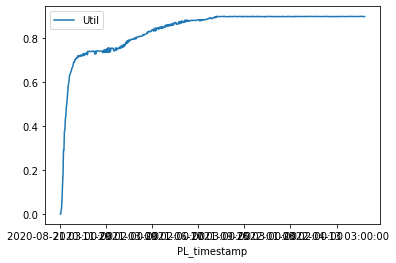

In [17]:
PL_Interest.loc[PL_Interest["PL_timestamp"]<"2022-06-14 02:00:00"].loc[PL_Interest["LP_Pool_id"]=="pid101"].plot.line(x="PL_timestamp",y="Util")

<AxesSubplot:xlabel='PL_timestamp'>

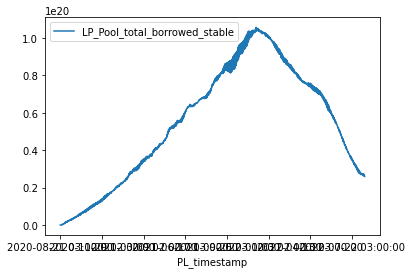

In [5]:
PL_Interest.plot.line(x="PL_timestamp",y="LP_Pool_total_borrowed_stable")

<AxesSubplot:xlabel='PL_timestamp'>

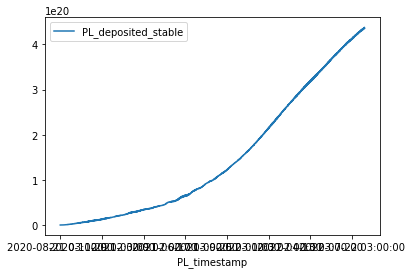

In [6]:
PL_Interest.plot.line(x="PL_timestamp",y="PL_deposited_stable")

<AxesSubplot:xlabel='PL_timestamp'>

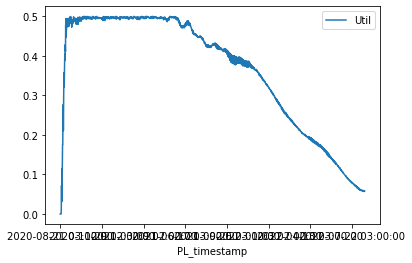

In [7]:
PL_Interest.plot.line(x="PL_timestamp",y="Util")

<AxesSubplot:xlabel='LS_timestamp'>

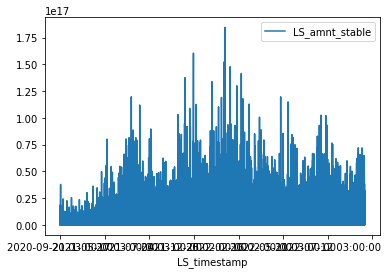

In [8]:
LS_Repayment.plot.line(x="LS_timestamp",y="LS_amnt_stable")

In [3]:
LS_Opening = pd.read_csv("LS_Opening_p2", index_col=0)
LP_Deposit = pd.read_csv("LP_Deposit_p2", index_col=0)
LP_Withdraw = pd.read_csv("LP_Withdraw_p2", index_col=0)
SYS_LP_Withdraw = pd.read_csv("SYS_LP_Withdraw_p2", index_col=0)
PL_Interest = pd.read_csv("PL_Interest_p2",index_col=0)
LS_Repayment = pd.read_csv("LS_Repayment_p2", index_col=0)
LS_Closing = pd.read_csv("LS_Closing", index_col=0)
LS_Liquidation = pd.read_csv("LS_Liquidation_p2", index_col=0)
LP_Pool_State = pd.read_csv("LP_Pool_State_p2", index_col=0)


In [4]:
TR_State = pd.read_csv("TR_State_p2", index_col=0)
TR_Profit = pd.read_csv("TR_Profit_p2", index_col=0)
TR_Rewards_Distibution = pd.read_csv("TR_Rewards_Distribution", index_col=0)

<AxesSubplot:xlabel='TR_Profit_timestamp'>

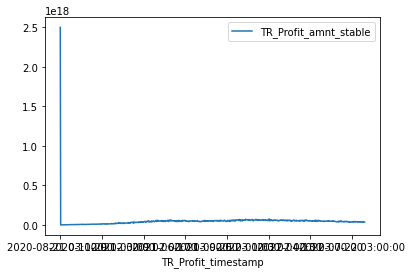

In [6]:
TR_Profit.plot.line(x = "TR_Profit_timestamp",y="TR_Profit_amnt_stable")

<AxesSubplot:xlabel='TR_timestamp'>

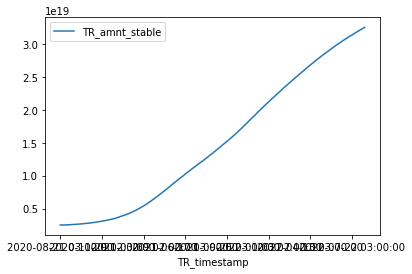

In [7]:
TR_State.plot.line(x ="TR_timestamp",y="TR_amnt_stable")

<AxesSubplot:xlabel='TR_Rewards_timestamp'>

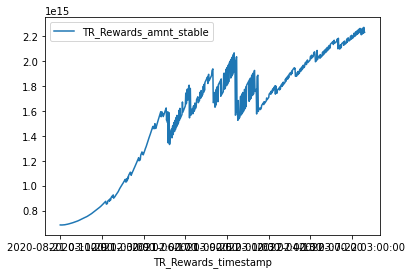

In [9]:
TR_Rewards_Distibution.loc[TR_Rewards_Distibution["TR_Rewards_Pool_id"]=="pid101"].plot.line(x="TR_Rewards_timestamp",y="TR_Rewards_amnt_stable")

In [13]:
#LP_Pool_State.loc[LP_Pool_State["LP_Pool_id"]=="pid101"].plot.line(x="LP_Pool_timestamp",y="LP_Pool_total_deposited_stable")
#PL_Interest.loc[PL_Interest["LP_Pool_id"]=="pid101"].plot.line(x="PL_timestamp",y="Util")
#LP_Pool_State.loc[LP_Pool_State["LP_Pool_id"]=="pid101"].plot.line(x="LP_Pool_timestamp",y="LP_Pool_total_borrowed_stable")

#SYS_LP_Withdraw.loc[SYS_LP_Withdraw["SYS_LP_contract_id"]==""]



<AxesSubplot:xlabel='PL_timestamp'>

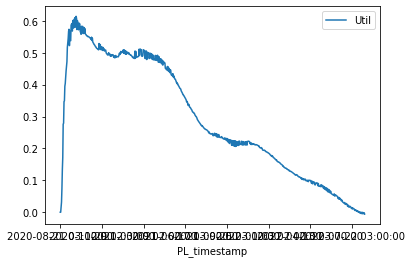

In [12]:
PL_Interest.loc[PL_Interest["LP_Pool_id"]=="pid101"].plot.line(x= "PL_timestamp", y = "Util" )

In [15]:
LS_Opening


,LS_asset_symbol,LS_timestamp,LS_contract_id,LS_address_id,LS_loan_symbol,LS_loan_amnt_asset,LS_loan_amnt_stable,LS_cltr_symbol,LS_cltr_amnt_stable,LS_cltr_amnt_asset,SYS_LS_cltr_amnt_asset,SYS_LS_loan_amnt_asset,LS_native_amnt_nolus,LS_native_amnt_stable,SYS_LS_expected_payment,SYS_LS_expected_penalty,LP_Pool_id,LS_interest
0,solana,2020-08-22 03:00:00,LScid1000000,LS_aid1000000,"('solana', None, 16)",146120851640169,4283606072121,solana,5936057173648,202488677762287,2.024887,1.461209,0,0,3,0,pid101,0.100000
1,ethereum,2020-08-22 03:00:00,LScid1000001,LS_aid1000001,"('ethereum', None, 13)",8041181306339,310878269545215,ethereum,394108143559885,10194006294830,1.019401,0.804118,0,0,2,0,pid101,0.100000
2,usd-coin,2020-08-22 03:00:00,LScid1000002,LS_aid1000002,"('usd-coin', None, 16)",501203184993,501020135184,usd-coin,659006249718,659247020416,0.659247,0.501203,0,0,3,1,pid100,0.100000
3,matic-network,2020-08-22 03:00:00,LScid1000003,LS_aid1000003,"('matic-network', None, 16)",10738170597123684,26797738702,matic-network,39790148758,15944382852572164,1.594438,1.073817,0,0,2,0,pid101,0.100000
4,crypto-com-chain,2020-08-22 03:00:00,LScid1000004,LS_aid1000004,"('crypto-com-chain', None, 15)",6969856732475531,117280371682,crypto-com-chain,121202182911,7202926102989536,0.720293,0.696986,0,0,5,8,pid101,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73043,tether,2022-08-21 03:00:00,LScid1073043,LS_aid1073043,"('tether', None, 12)",1158363644598,1159646859896,tether,1190204761684,1188887732327,1.188888,1.158364,0,0,1,0,pid101,0.099854
73044,bitcoin,2022-08-21 03:00:00,LScid1073044,LS_aid1073044,"('bitcoin', None, 12)",1233262442095,26122219920255380,bitcoin,26956457674587960,1272647842469,1.272648,1.233262,0,0,1,0,pid101,0.099854
73045,wrapped-bitcoin,2022-08-21 03:00:00,LScid1073045,LS_aid1073045,"('wrapped-bitcoin', None, 12)",1522935880862,32224525557920664,wrapped-bitcoin,35167825880797500,1662036692814,1.662037,1.522936,0,0,5,0,pid101,0.099854
73046,tether,2022-08-21 03:00:00,LScid1073046,LS_aid1073046,"('tether', None, 12)",1236486906930,1237171596812,tether,1280949110456,1280240192713,1.280240,1.236487,0,0,6,0,pid100,0.099608


In [21]:
(LS_Opening["SYS_LS_expected_payment"] + LS_Opening["SYS_LS_expected_penalty"]).mean()

5.646807578578469

In [18]:
LP_Deposit["LP_amnt_stable"].mean()/10**12

20723.763370910503

In [19]:
LP_Deposit["SYS_LP_expected_duration"].mean()


8.751505199781063

In [3]:
SYS_LP_Withdraw
SYS_LP_Withdraw = pd.read_csv("SYS_LP_Withdraw_p2", index_col=0)


In [7]:
SYS_LP_Withdraw.loc[SYS_LP_Withdraw["SYS_LP_contract_id"] == "lpaid1000000100"]


,LP_timestamp,LP_address_id,SYS_LP_contract_id,LP_Pool_id,LP_withdraw_height,LP_withdraw_idx,LP_amnt_stable,LP_interest,LP_interest_amnt
0,2020-08-23 03:00:00,lpaid1000000,lpaid1000000100,pid100,100,100,NaN,0.081195,6.165228e+12
1,2020-08-24 03:00:00,lpaid1000000,lpaid1000000100,pid100,101,101,NaN,0.085062,6.458924e+12
2,2020-08-25 03:00:00,lpaid1000000,lpaid1000000100,pid100,102,102,NaN,0.088226,6.699168e+12
3,2020-08-26 03:00:00,lpaid1000000,lpaid1000000100,pid100,103,103,NaN,0.092550,7.027478e+12
4,2020-08-27 03:00:00,lpaid1000000,lpaid1000000100,pid100,104,104,NaN,0.092556,7.027900e+12
...,...,...,...,...,...,...,...,...,...
325,2021-07-14 03:00:00,lpaid1000000,lpaid1000000100,pid100,425,425,NaN,0.140000,1.063041e+13
326,2021-07-15 03:00:00,lpaid1000000,lpaid1000000100,pid100,426,426,NaN,0.140000,1.063041e+13
327,2021-07-16 03:00:00,lpaid1000000,lpaid1000000100,pid100,427,427,NaN,0.140000,1.063041e+13
328,2021-07-17 03:00:00,lpaid1000000,lpaid1000000100,pid100,428,428,NaN,0.140000,1.063041e+13


In [8]:
27715000000000000*0.081195


2250319425000000.0

In [10]:
LS_Repayment = pd.read_csv("LS_Repayment_p2", index_col=0)
LS_Opening.loc[LS_Opening["LS_contract_id"] == "LScid1000000"]

In [12]:
LS_Opening.loc[LS_Opening["LS_contract_id"] == "LScid1000000"]

,LS_asset_symbol,LS_timestamp,LS_contract_id,LS_address_id,LS_loan_symbol,LS_loan_amnt_asset,LS_loan_amnt_stable,LS_cltr_symbol,LS_cltr_amnt_stable,LS_cltr_amnt_asset,SYS_LS_cltr_amnt_asset,SYS_LS_loan_amnt_asset,LS_native_amnt_nolus,LS_native_amnt_stable,SYS_LS_expected_payment,SYS_LS_expected_penalty,LP_Pool_id,LS_interest
0,solana,2020-08-22 03:00:00,LScid1000000,LS_aid1000000,"('solana', None, 16)",146120851640169,4283606072121,solana,5936057173648,202488677762287,2.024887,1.461209,0,0,3,0,pid101,NaN


In [11]:
LS_Repayment

,LS_timestamp,LS_contract_id,LS_repayment_height,LS_repayment_idx,LS_symbol,LS_amnt_stable,LS_principal_stable,LS_current_margin_stable,LS_current_interest_stable,LS_prev_interest_stable,LS_prev_margin_stable
0,2020-09-21 03:00:00,LScid1000000,100,100,tether,1.570656e+12,1.427869e+12,3.569672e+10,3.569672e+10,3.569672e+10,3.569672e+10
1,2020-10-21 03:00:00,LScid1000000,101,101,tether,1.570656e+12,1.427869e+12,3.569672e+10,3.569672e+10,3.569672e+10,3.569672e+10
2,2020-11-20 02:00:00,LScid1000000,102,102,tether,1.570656e+12,1.427869e+12,3.569672e+10,3.569672e+10,3.569672e+10,3.569672e+10
3,2020-09-21 03:00:00,LScid1000001,103,103,tether,1.709830e+14,1.554391e+14,3.885978e+12,3.885978e+12,3.885978e+12,3.885978e+12
4,2020-10-21 03:00:00,LScid1000001,104,104,tether,1.709830e+14,1.554391e+14,3.885978e+12,3.885978e+12,3.885978e+12,3.885978e+12
...,...,...,...,...,...,...,...,...,...,...,...
412105,2022-10-19 03:00:00,LScid1072946,412205,412205,usd-coin,3.774210e+14,3.253630e+14,1.301452e+13,1.301452e+13,1.301452e+13,1.301452e+13
412106,2022-11-18 02:00:00,LScid1072946,412206,412206,usd-coin,3.774210e+14,3.253630e+14,1.301452e+13,1.301452e+13,1.301452e+13,1.301452e+13
412107,2022-12-18 02:00:00,LScid1072946,412207,412207,usd-coin,3.774210e+14,3.253630e+14,1.301452e+13,1.301452e+13,1.301452e+13,1.301452e+13
412108,2023-01-17 02:00:00,LScid1072946,412208,412208,usd-coin,3.774210e+14,3.253630e+14,1.301452e+13,1.301452e+13,1.301452e+13,1.301452e+13


In [15]:
4283606072121*0.1 + 4283606072121

4711966679333.1

In [16]:
4711966679333.1/3

1570655559777.7